<a href="https://colab.research.google.com/github/DariaEng2704/Final-Project/blob/main/Wine_Testing_Project_with_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Quality of Wine - She Codes Final Project***



by Daria Engel


The current project will provide supervised predictive models to identify the quality of wines, based on a variety of parameters, as country of origin, price, and variety of the wine. 
The provided models will help us to predict the quality of a wine, and therefore, help us to understand is it worth buying. 


# **Import the modules**

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import style
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from termcolor import colored as cl
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix 
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report

try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Note: using Google CoLab




# **Import the data**


We will load in a dataset from the **[Kaggle website](https://www.kaggle.com/)**.
Specifically, we are going to use the **[Wine Reviews Dataset](https://www.kaggle.com/zynicide/wine-reviews?select=winemag-data-130k-v2.csv)**.

In [3]:
from google.colab import files
uploaded = files.upload()

data = pd.read_csv('winemag-data-130k-v2.csv')
df = pd.DataFrame(data)




# Preview of the first 5 rows of the data:

df.head()

Saving winemag-data-130k-v2.csv to winemag-data-130k-v2.csv


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
# We will remove the first column, which contains the numbering of the rows.

df = df.drop(df.columns[0], axis=1) 
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


The columns included in the data are : 

+ **country** - the country the wine comes from.
+ **description** - the description of the wine by the taster.
+ **designation** - the vineyard within the winery provided the grapes for the wine.
+ **points** - the number of points the taster rated the wine on a scale of 1-100 (the current dataset includes only a range of 80-100 as the website which provided the datadset posts those scores only. 
+ **price** - the cost of a bottle of wine.
+ **province** - the province or state the wine comes from.
+ **region_1** - the wine-growing area in a province or state.
+ **region_2** - specific regions specified within a wine-growing area.
+ **taster_name** - the name of the taster of the wine. 
+ **taster_twitter_handle** - the Twitter username of the taster.
+ **title** - the title of the wine.
+ **variety** - the variety of the wine.
+ **winery** - the winery the wine was made by. 


# **Identifying Missing Data**

In the current section, we will focus on identifying the missing data in the dataset. 
First, we will check the type of data in each column :

In [5]:
df.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

After checking that all the suggested data types are matching the real data types, we will drop the duplicate samples -  


In [6]:
print ("Data size prior duplicates removal: " + str(len(df.axes[0])) + " rows and " + str(len(df.axes[1])) + " columns.")
df = df.drop_duplicates()
print ("Data size after duplicates removal: " + str(len(df.axes[0])) + " rows and " + str(len(df.axes[1])) + " columns.")

Data size prior duplicates removal: 129971 rows and 13 columns.
Data size after duplicates removal: 119988 rows and 13 columns.


Now, we will make a summary table with  
 + Features with missing data
 + The percent of the missing data for each feature
 + How many unique values each feature have

In [7]:
nulls = df.isnull().sum()
percentage_nulls = 100 * nulls / len(df)
data_types = df.dtypes
unique_values = df.nunique()
missing_values_table = pd.concat([nulls, percentage_nulls,unique_values, data_types], axis=1)
missing_values_table = missing_values_table.rename(columns = {0 : 'Missing Values', 1 : 'Percentage', 2: 'Unique Values', 3 : 'Data Types'})
missing_values_table

,Missing Values,Percentage,Unique Values,Data Types
country,59,0.049172,43,object
description,0,0.000000,119955,object
designation,34545,28.790379,37979,object
points,0,0.000000,21,int64
price,8395,6.996533,390,float64
province,59,0.049172,425,object
region_1,19560,16.301630,1229,object
region_2,73219,61.021936,17,object
taster_name,24917,20.766243,19,object
taster_twitter_handle,29446,24.540787,15,object


# **Missing Data Imputation**

#### First, we will start with **observations** dropping : 
  + The features **"country"**, **"province"** and **"variety"** have a negligible amount of missing values. Therefore, we will remove the samples with those values : 

In [8]:
df_no_small_missing = df[(df['country'].notnull())  & (df['variety'].notnull()) & (df['province'].notnull())]
df_no_small_missing.isnull().sum()

country                      0
description                  0
designation              34534
points                       0
price                     8391
province                     0
region_1                 19500
region_2                 73159
taster_name              24916
taster_twitter_handle    29445
title                        0
variety                      0
winery                       0
dtype: int64

#### Secondly, we will drop some **features** : 

+ The **"designation"** variable will not be used since 30% of the data is missing and the rest 70% includes many unique values (every second value is unique), which makes it not very useful to use. 
+ The **"region_2"** variable has a very high percentage of missing data (61%), so we will drop it. This variable only contains regions in the USA and irrelevant to all other countries (see below).

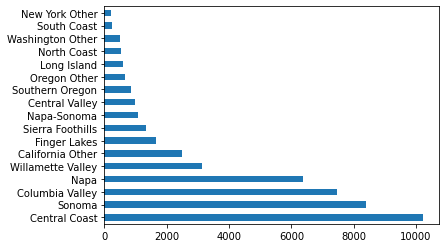

In [9]:
df_no_small_missing['region_2'].value_counts().plot(kind='barh')

+ For now, we will also drop the **"description"** variable, since it requires an NLP model. 
+ The variables **"title"** and **"taster_twitter_handle"** will be dropped. 
  + "title" data is very specific and unique, which is not informative for the models. 
  + "taster name" is covered by the "taster_name" variable. 

In [10]:
# Drop of all mentioned above columns 

df_relevant_features = df_no_small_missing.drop(['description','designation','region_2','title','taster_twitter_handle'], axis=1) 
df_relevant_features.head()

,country,points,price,province,region_1,taster_name,variety,winery
0,Italy,87,NaN,Sicily & Sardinia,Etna,Kerin O’Keefe,White Blend,Nicosia
1,Portugal,87,15.0,Douro,NaN,Roger Voss,Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Pinot Gris,Rainstorm
3,US,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,Riesling,St. Julian
4,US,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Pinot Noir,Sweet Cheeks


In [11]:
nulls = df_relevant_features.isnull().sum()
percentage_nulls = 100 * nulls / len(df_relevant_features)
data_types = df_relevant_features.dtypes
unique_values = df_relevant_features.nunique()
missing_values_table = pd.concat([nulls, percentage_nulls,unique_values, data_types], axis=1)
missing_values_table = missing_values_table.rename(columns = {0 : 'Missing Values', 1 : 'Percentage', 2: 'Unique Values', 3 : 'Data Types'})
missing_values_table

,Missing Values,Percentage,Unique Values,Data Types
country,0,0.000000,43,object
points,0,0.000000,21,int64
price,8391,6.996698,390,float64
province,0,0.000000,425,object
region_1,19500,16.259756,1229,object
taster_name,24916,20.775799,19,object
variety,0,0.000000,701,object
winery,0,0.000000,16745,object


## **Missing Data Imputaion - "price" variable** 

We will start by imputing the missing data in the "price" variable (integer). The missing values will be replaced with a median of a price in each province, with a belief that these groups are homogeneous enough to obtain relatively accurate results.


In [12]:
df_relevant_features['price'] = df_relevant_features.groupby('province')['price'].transform(lambda x: x.fillna(x.median()))
print(df_relevant_features.isnull().sum())

country            0
points             0
price              3
province           0
region_1       19500
taster_name    24916
variety            0
winery             0
dtype: int64


We left with 3 missing values for the "price" variable. As possible to see below, all three have only one value per province and this value is missing. 


In [13]:
print (df_relevant_features.loc[pd.isna(df_relevant_features['price'])]['province'].value_counts())


Ceres Plateau      1
Piekenierskloof    1
Egypt              1
Name: province, dtype: int64


In [14]:
df_relevant_features.loc[pd.isna(df_relevant_features['price'])]

,country,points,price,province,region_1,taster_name,variety,winery
16766,South Africa,88,NaN,Ceres Plateau,NaN,Lauren Buzzeo,Pinot Noir,De Grendel
34865,South Africa,91,NaN,Piekenierskloof,NaN,Lauren Buzzeo,Red Blend,Neil Ellis
110246,Egypt,84,NaN,Egypt,NaN,Susan Kostrzewa,Grenache,Sahara Vineyards


Therefore, we will fill in those 3 values with the general median of all the data. 

In [15]:
df_relevant_features['price'].fillna(df_relevant_features['price'].median(), inplace=True)
print(df_relevant_features.isnull().sum())


country            0
points             0
price              0
province           0
region_1       19500
taster_name    24916
variety            0
winery             0
dtype: int64


## **Missing Data Imputaion - "taster_name" variable**

Now we will impute the missing data in the "taster_name" variable (character). The missing values will be replaced with the value "unknown", since we don't know whether the names are missing due to lack of documintation or deu to the fact that only the major tasters are mentioned in the list. 

In [16]:
df_relevant_features['taster_name'].fillna('other', inplace=True)
print(df_relevant_features.isnull().sum())

country            0
points             0
price              0
province           0
region_1       19500
taster_name        0
variety            0
winery             0
dtype: int64


## **Missing Data Imputaion - "region_1" variable**


We only left with the "region_1" variable missing data. 
First, we will check what are countries covered in the "region_1" variable - 

In [17]:
df_relevant_features.loc[pd.isna(df_relevant_features['region_1']) == False]['country'].value_counts()

US           50202
France       20282
Italy        17918
Spain         6109
Argentina     3495
Australia     2196
Canada         226
Name: country, dtype: int64

As we can see, the "region_1" feature includes data of only 7 countries out of all 43 countries which appear in the dataset. This means that it is impossible to fill in the missing data of all the other 36 countries. 
Therefore, the missing values will be replaced with "null". 

In [18]:
df_relevant_features['region_1'].fillna('other', inplace=True)
print(df_relevant_features.isnull().sum())

country        0
points         0
price          0
province       0
region_1       0
taster_name    0
variety        0
winery         0
dtype: int64


As a summary, after handling the missing data and dropping irrelevant columns, these are the columns we will use for the models. 

In [19]:
nulls_final = df_relevant_features.isnull().sum()
percentage_nulls_final = 100 * nulls_final / len(df_relevant_features)
data_types_final = df_relevant_features.dtypes
unique_values_final = df_relevant_features.nunique()
missing_values_table_final = pd.concat([nulls_final, percentage_nulls_final,unique_values_final, data_types_final], axis=1)
missing_values_table_final = missing_values_table_final.rename(columns = {0 : 'Missing Values', 1 : 'Percentage', 2: 'Unique Values', 3 : 'Data Types'})
missing_values_table_final

,Missing Values,Percentage,Unique Values,Data Types
country,0,0.0,43,object
points,0,0.0,21,int64
price,0,0.0,405,float64
province,0,0.0,425,object
region_1,0,0.0,1230,object
taster_name,0,0.0,20,object
variety,0,0.0,701,object
winery,0,0.0,16745,object


# **Data Distribution**

Before starting working on the models for wine quality prediction, we will check the data distribution of both features and labels. If needed, we will transform the data in order to get a better quality model.  

### **"country" Data Distribution**

In [20]:
df_relevant_features['country'].value_counts()

US                        50457
France                    20353
Italy                     17940
Spain                      6116
Portugal                   5256
Chile                      4183
Argentina                  3544
Austria                    3034
Australia                  2197
Germany                    1992
South Africa               1301
New Zealand                1278
Israel                      466
Greece                      432
Canada                      226
Bulgaria                    132
Hungary                     129
Romania                     102
Uruguay                      98
Turkey                       81
Slovenia                     77
Georgia                      76
Croatia                      70
Mexico                       68
England                      63
Moldova                      56
Brazil                       49
Lebanon                      32
Morocco                      24
Peru                         16
Ukraine                      14
Czech Re

As we see, the big volume of the data is covered by the USA, France, and Italy. 

### **"points" Data Distribution**

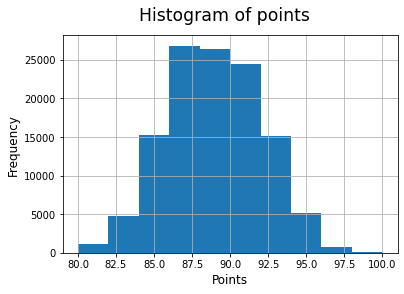

In [21]:
df_relevant_features['points'].hist()
plt.suptitle('Histogram of points', fontsize='xx-large')
plt.xlabel('Points', fontsize='large')
plt.ylabel('Frequency', fontsize='large')
print ()

In [22]:
print ("The mean of the points is : {}".format(df_relevant_features['points'].mean()))
print ("The standard deviation of the points is : {}".format(df_relevant_features['points'].std()))

The mean of the points is : 88.44214862250683
The standard deviation of the points is : 3.093287251240293


The scores are normally distributed with mean = 88.5 and standard deviation = 3. 

### **"price" Data Distribution**

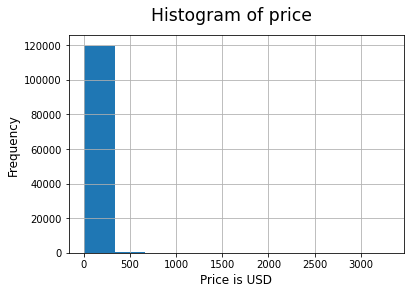

In [23]:
# An histogram of the "price" variable. 

df_relevant_features['price'].hist()
plt.suptitle('Histogram of price', fontsize='xx-large')
plt.xlabel('Price is USD', fontsize='large')
plt.ylabel('Frequency', fontsize='large')
print ()

It seems that the outliers in the data prevent are from seeing the distribution of the major amount of data, with much lower prices than the range presented in this histogram. 

To get a better view, we will first create a boxplot, which will show us the possible outliers in a better way. 

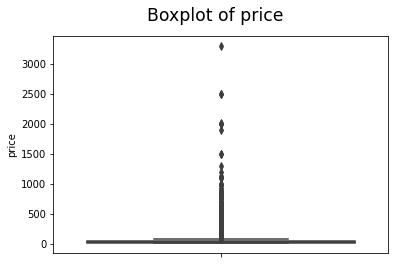

In [24]:
import seaborn as sns
sns.boxplot(y = df_relevant_features['price'])
plt.suptitle('Boxplot of price', fontsize='xx-large')
print ()

In the boxplot, we see that most of the prices are lower than ~100. Therefore, we will create a histogram that will provide us a better view of the price distribution. In order to do that, we will summarize all values higher than 100 to one bin.

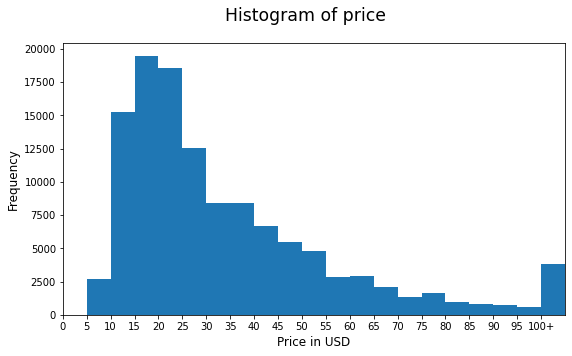

In [25]:
def plot_histogram():
    bins = np.arange(0,110,5)
    fig, ax = plt.subplots(figsize=(9, 5))
    _, bins, patches = plt.hist([np.clip(df_relevant_features['price'], bins[0], bins[-2])], density=False, bins=bins)
    xlabels = bins[0:].astype(str)
    xlabels[-2] += '+'
    N_labels = len(xlabels)-1
    plt.xlim([0, 105])
    plt.xticks(5 * np.arange(N_labels))
    ax.set_xticklabels(xlabels)
    plt.suptitle('Histogram of price', fontsize='xx-large')
    plt.xlabel('Price in USD', fontsize='large')
    plt.ylabel('Frequency', fontsize='large')
    print ()
plot_histogram()

As we can see, most of the wines cost between 10-30 USD.

Since our data has a right-skewed distribution, we would make a **log transformation**. We expect that the transformation would provide asymptotically normally distributed data.

Since the lowest price is 4 and most of the values are below 100, we will present a histogram with a log of 4 to 100 (~1.25 to ~4.75 in log values). All the values higher than 4.75 are summarized and presented in the last bin. 

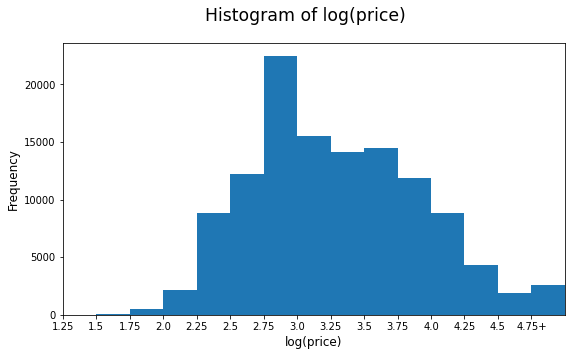

In [26]:
def plot_histogram_1():
    bins = np.arange(1.25,5.25,0.25)
    fig, ax = plt.subplots(figsize=(9, 5))
    _, bins, patches = plt.hist([np.clip(df_relevant_features['price'].apply(np.log), bins[0], bins[-2])], density=False, bins=bins)
    xlabels = bins[0:].astype(str)
    xlabels[-2] += '+'
    N_labels = len(xlabels)-1
    plt.xlim([1.25,5])
    plt.xticks(0.25 * np.arange(N_labels) + 1.25)
    ax.set_xticklabels(xlabels)
    plt.suptitle('Histogram of log(price)', fontsize='xx-large')
    plt.xlabel('log(price)', fontsize='large')
    plt.ylabel('Frequency', fontsize='large')
    print () 
plot_histogram_1()

The transformed "price" variable has indeed a distribution that is much closer to be normal than the original distribution. Hence, we will use log(price) as a feature. 

In [27]:
df_relevant_features['price_log'] = np.log(df_relevant_features['price'])

### **"taster_name" Data Distribution**

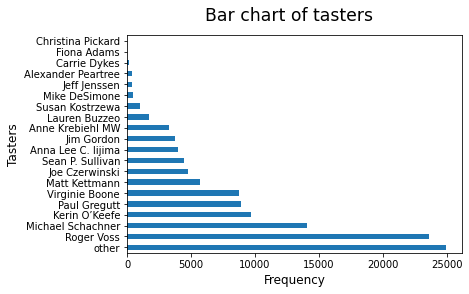

In [28]:
df_relevant_features['taster_name'].value_counts().plot(kind='barh')
plt.suptitle('Bar chart of tasters', fontsize='xx-large')
plt.xlabel('Frequency', fontsize='large')
plt.ylabel('Tasters', fontsize='large')
print ()

We will skip other features since they have a big number of categories each and the summary will not be as informative as the summaries presented above. 

In [29]:

data_types_final = df_relevant_features.dtypes
unique_values_final = df_relevant_features.nunique()
missing_values_table_final = pd.concat([unique_values_final, data_types_final], axis=1)
missing_values_table_final = missing_values_table_final.rename(columns = {0 : 'Unique Values', 1 : 'Data Types'})
missing_values_table_final

,Unique Values,Data Types
country,43,object
points,21,int64
price,405,float64
province,425,object
region_1,1230,object
taster_name,20,object
variety,701,object
winery,16745,object
price_log,405,float64


In our future models, we will use an One-Hot Encoding for categorical variables. Since this encode will increase the amount of features to be a very high, will slow the running time and use a big amount of memory. 
In order to reduce all that, categories with a low amount of values (<100 in our case) will be replaced by the value "other".  

In [30]:
cols = ['province','region_1','variety', 'winery']
for col in cols:
    val = df_relevant_features[col].value_counts()
    y = val[val < 100].index
    df_relevant_features[col] = df_relevant_features[col].replace({x:'other' for x in y})

In [31]:
data_types_final = df_relevant_features.dtypes
unique_values_final = df_relevant_features.nunique()
missing_values_table_final = pd.concat([unique_values_final, data_types_final], axis=1)
missing_values_table_final = missing_values_table_final.rename(columns = {0 : 'Unique Values', 1 : 'Data Types'})
missing_values_table_final

,Unique Values,Data Types
country,43,object
points,21,int64
price,405,float64
province,82,object
region_1,197,object
taster_name,20,object
variety,87,object
winery,22,object
price_log,405,float64


After replacing the values to "other", we will encode the categorical features to One-Hot features. 

In [32]:
df_relevant_features_new = pd.get_dummies(df_relevant_features, columns = ['country', 'province', 'region_1','taster_name','variety','winery'])

Since we transrformed the 'price' variable to be log, we will drop the 'price' column. 

In [33]:
df_relevant_features_new.drop('price', axis=1, inplace=True)
df_relevant_features_new.head()


,points,price_log,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Bosnia and Herzegovina,country_Brazil,country_Bulgaria,country_Canada,country_Chile,country_China,country_Croatia,country_Cyprus,country_Czech Republic,country_Egypt,country_England,country_France,country_Georgia,country_Germany,country_Greece,country_Hungary,country_India,country_Israel,country_Italy,country_Lebanon,country_Luxembourg,country_Macedonia,country_Mexico,country_Moldova,country_Morocco,country_New Zealand,country_Peru,country_Portugal,country_Romania,country_Serbia,country_Slovakia,country_Slovenia,country_South Africa,country_Spain,...,variety_Sémillon,variety_Tannat,variety_Tempranillo,variety_Tempranillo Blend,variety_Tinta de Toro,variety_Torrontés,variety_Touriga Nacional,variety_Turbiana,variety_Verdejo,variety_Verdicchio,variety_Vermentino,variety_Vernaccia,variety_Viognier,variety_Viura,variety_White Blend,variety_Zinfandel,variety_Zweigelt,variety_other,winery_Albert Bichot,winery_Chateau Ste. Michelle,winery_Columbia Crest,winery_Concha y Toro,winery_DFJ Vinhos,winery_Gary Farrell,winery_Georges Duboeuf,winery_Jean-Luc and Paul Aegerter,winery_Kendall-Jackson,winery_Louis Jadot,winery_Louis Latour,winery_Lynmar,winery_Montes,winery_Robert Mondavi,winery_Santa Ema,winery_Siduri,winery_Testarossa,winery_Trapiche,winery_Undurraga,winery_Williams Selyem,winery_Wines & Winemakers,winery_other
0,87,3.091042,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,87,2.708050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,87,2.639057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,87,2.564949,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,87,4.174387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# **Regression Models**

### **Linear Regression Model**

As a starting point, we will create a basic Linear Regression Model, which will include only two numeric variables that are included in the dataset - price, and points. We will check the proportion of the variance for the points that is explained by the price. 

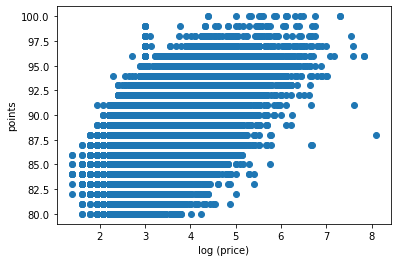

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                 6.520e+04
Date:                Mon, 09 Aug 2021   Prob (F-statistic):               0.00
Time:                        08:26:27   Log-Likelihood:            -2.7956e+05
No. Observations:              119928   AIC:                         5.591e+05
Df Residuals:                  119926   BIC:                         5.592e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.0082      0.038   2099.040      0.000      78.934      79.082
price_log      2.8480      0.011    255.335      0.000       2.826       2.870
==============================================================================
Omnibus:                     1347.142   Durbin-Watson:                   0.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1407.971
Skew:                          -0.250   Prob(JB):                    1.83e-306
Kurtosis:                       3.176   Cond. No.                         19.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
x1 = df_relevant_features_new['price_log'] # independent variable
y = df_relevant_features_new['points'] # dependent variable
plt.scatter(x1, y)
plt.xlabel('log (price)', fontsize = 10)
plt.ylabel('points', fontsize = 10)
plt.show()

x = sm.add_constant(x1)

lr_model = sm.OLS(y, x).fit() # Ordinary Least Squares 
lr_model.summary()

As we see in the graph and in the summary table, there is some linear relationship between the log of the prices and the scores. 
The R^2 value is 0.352, means the proportion of the variance for the points that is explained by the price is equal to 0.352. 
We also see that both the log(price) and the intercept are significant, means the log(price) is a significant variable when predicting the points. 

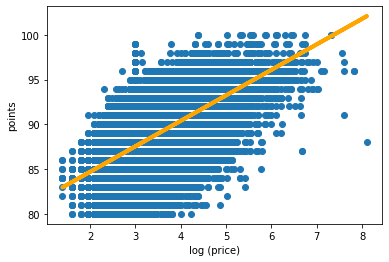

In [35]:
plt.scatter(x1, y)
yhat = 2.8480*x1 + 79.008
fig = plt.plot(x1,yhat, lw=4, c='orange', label = 'regression line')
plt.xlabel('log (price)', fontsize = 10)
plt.ylabel('points', fontsize = 10)
plt.show()

After creating a basic Linear Regression Model, we will move further to machine learning regression models, and will check how adding categorical features (presented as one-hot features) and using more advanced models will improve the predictions. 

Later, we will create categorical models, and will try to predict the quality of the wine, when the label will be used as a categorical label with two categories - "Poor quality" and "Good quality". 

## **Keras Regression Model**

We wil start with Neural Network Keras Regression Model. 

In [36]:
x_columns_reg = df_relevant_features_new.columns.drop('points')
x_reg = df_relevant_features_new[x_columns_reg].values
y_reg = df_relevant_features_new['points'].values

# Create train/test
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(    
    x_reg, y_reg, test_size=0.2, random_state=42)


In [37]:
# Build the neural network
model = Sequential()
model.add(Dense(25, input_dim=x_reg.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=5, verbose=1, mode='auto', 
                        restore_best_weights=True)
model.fit(x_train_reg,y_train_reg,validation_data=(x_test_reg,y_test_reg),
          callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
2999/2999 - 5s - loss: 470.0559 - val_loss: 7.7416
Epoch 2/1000
2999/2999 - 4s - loss: 5.7272 - val_loss: 5.5424
Epoch 3/1000
2999/2999 - 4s - loss: 5.3697 - val_loss: 5.6659
Epoch 4/1000
2999/2999 - 4s - loss: 5.3052 - val_loss: 5.6530
Epoch 5/1000
2999/2999 - 4s - loss: 5.2636 - val_loss: 5.3106
Epoch 6/1000
2999/2999 - 4s - loss: 5.2173 - val_loss: 5.2764
Epoch 7/1000
2999/2999 - 4s - loss: 5.1872 - val_loss: 5.2260
Epoch 8/1000
2999/2999 - 4s - loss: 5.1798 - val_loss: 5.2555
Epoch 9/1000
2999/2999 - 4s - loss: 5.1319 - val_loss: 5.4809
Epoch 10/1000
2999/2999 - 4s - loss: 5.1392 - val_loss: 5.5721
Epoch 11/1000
2999/2999 - 4s - loss: 5.1181 - val_loss: 5.2192
Epoch 12/1000
2999/2999 - 4s - loss: 5.1065 - val_loss: 5.2002
Epoch 13/1000
2999/2999 - 4s - loss: 5.0988 - val_loss: 5.2339
Epoch 14/1000
2999/2999 - 4s - loss: 5.0942 - val_loss: 5.2821
Epoch 15/1000
2999/2999 - 4s - loss: 5.0817 - val_loss: 5.2586
Epoch 16/1000
2999/2999 - 4s - loss: 5.0730 - val_loss: 5.2388

In [38]:
# Predict
y_pred_keras = model.predict(x_test_reg)

# Measure MSE and RMSE error.  

score1 = metrics.mean_squared_error(y_pred_keras,y_test_reg)
print("Final score (MSE): {}".format(score1))
score2 = np.sqrt(metrics.mean_squared_error(y_pred_keras,y_test_reg))
print("Final score (RMSE): {}".format(score2))

Final score (MSE): 5.200224055952421
Final score (RMSE): 2.280399977186551


In [39]:
# Calculating R2 value

y_pred_train_keras = model.predict(x_train_reg)

score_train_keras = r2_score(y_train_reg, y_pred_train_keras)
score_test_keras = r2_score(y_test_reg, y_pred_keras)
print("R^2 for train data: {}".format(score_train_keras))
print("R^2 for test data: {}".format(score_test_keras))


R^2 for train data: 0.48129174540924724
R^2 for test data: 0.4510138560954764


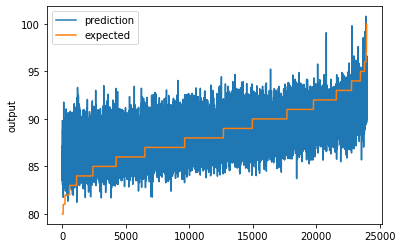

In [40]:
# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.plot(t['y'].tolist(), label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()
chart_regression(y_pred_keras.flatten(), y_test_reg)

As we see, the RMSE value is 2.28 and the R^2 value for the test data is 0.45. 

We will build aditional Regression model and compare the scores.  

## **XGBoost Regression Model**

In [41]:
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=2,
    gamma=0,
    max_depth=3
)

In [42]:
regressor.fit(x_train_reg, y_train_reg)


[08:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [43]:
y_pred_XG = regressor.predict(x_test_reg)

# Measure MSE and RMSE errors  

score1_XG = metrics.mean_squared_error(y_pred_XG,y_test_reg)
print("Final score (MSE): {}".format(score1_XG))
score2_XG = np.sqrt(metrics.mean_squared_error(y_pred_XG,y_test_reg))
print("Final score (RMSE): {}".format(score2_XG))

Final score (MSE): 5.432604381609079
Final score (RMSE): 2.3307947961176416


In [44]:
# Calculating R2 value

y_pred_train_XG = regressor.predict(x_train_reg)
score_train_XG = r2_score(y_train_reg,y_pred_train_XG)
score_test_XG = r2_score(y_test_reg,y_pred_XG)
print("R^2 for train data: {}".format(score_train_XG))
print("R^2 for test data: {}".format(score_test_XG))

R^2 for train data: 0.4458723615873902
R^2 for test data: 0.4264815325784733


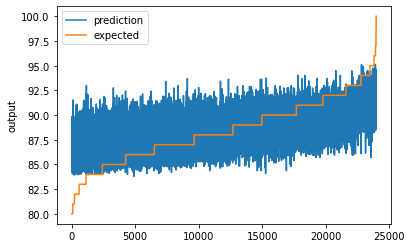

In [45]:
# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.plot(t['y'].tolist(), label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()
chart_regression(y_pred_XG.flatten(), y_test_reg)

XDBoost Regression model provides a bit lower scores than the Keras Regression model. Both scores are not really good and do not provide a very good prediction for the quality of the wine. 
In addition, in the Regression chart we see that the predcition in XGBoost model have less variance than the predictions in Keras Model and almost don`t show any trend.

# **Binary Classification Models**

After predicting the scores of the wines using models with  a numeric label, we will encode our label to be a two-categories label (poor/good quality wine). Following that, the models shown below will be binary classification models.  

In [46]:
df_relevant_features_new['points_cat'] = np.where(df_relevant_features_new["points"]>=89, 1, 2) 
df_relevant_features_new['points_cat'].value_counts()


2    63227
1    56701
Name: points_cat, dtype: int64

In [47]:
df_relevant_features_new.drop('points', axis=1, inplace=True)


In [48]:
x_columns_class = df_relevant_features_new.columns.drop('points_cat')
x_class = df_relevant_features_new[x_columns_class].values
y_class = df_relevant_features_new['points_cat'].values

# Create train/test
x_train_class, x_test_class, y_train_class, y_test_class = train_test_split(    
    x_class, y_class, test_size=0.2, random_state=42)

## **Naive Bayes Model**

In [49]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(x_train_class, y_train_class)

#Predict the response for test dataset
y_pred_NB = gnb.predict(x_test_class)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


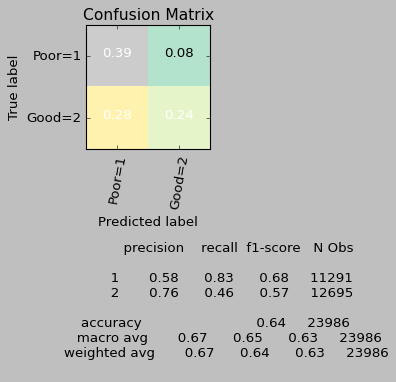

In [50]:
# Confusion matrix 

def pretty_print_conf_matrix(y_true, y_pred, 
                             classes,
                             normalize=False,
                             title='Confusion matrix',
                             cmap=plt.cm.Pastel2):
    
    cm = confusion_matrix(y_true, y_pred)

    # Configure Confusion Matrix Plot Aesthetics (no text yet) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=80)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    # Calculate normalized values (so all cells sum to 1) if desired
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    # Place Numbers as Text on Confusion Matrix Plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)


    # Add Precision, Recall, F-1 Score as Captions Below Plot
    rpt = classification_report(y_true, y_pred)
    rpt = rpt.replace('avg / total', '      avg')
    rpt = rpt.replace('support', 'N Obs')

    plt.annotate(rpt, 
                 xy = (0,0), 
                 xytext = (-20, -200), 
                 xycoords='axes fraction', textcoords='offset points',
                 fontsize=12, ha='left')    

    # Plot
    plt.tight_layout()


# Plot Confusion Matrix
plt.style.use('classic')
plt.figure(figsize=(2,2))
pretty_print_conf_matrix(y_test_class, y_pred_NB, 
                         classes= ['Poor=1', 'Good=2'],
                         normalize=True, 
                         title='Confusion Matrix')

The confusion matrix showed us that the accuracy value is 0.64, which means the models classified correctly only 64% of the data. 
In order to try and improve the model, we will run the same model, but this time we will change to price feature to be a categorical feature.

In [51]:
bins = [0, 2.75, 3, 3.5, 4, np.inf]
names = ['1', '2', '3', '4', '5']

df_relevant_features_new['price_log_cat'] = pd.cut(df_relevant_features_new['price_log'], bins, labels=names)
df_relevant_features_new['price_log_cat'].value_counts()

3    29652
4    26375
1    23795
2    22475
5    17631
Name: price_log_cat, dtype: int64

In [52]:
x_columns_class_all_cat = df_relevant_features_new.columns.drop('points_cat').drop('price_log')
x_class_all_cat = df_relevant_features_new[x_columns_class_all_cat].values
y_class_all_cat = df_relevant_features_new['points_cat'].values

# Create train/test

x_train_class_all_cat, x_test_class_all_cat, y_train_class_all_cat, y_test_class_all_cat = train_test_split(    
    x_class_all_cat, y_class_all_cat, test_size=0.2, random_state=42)


In [53]:
#Create a Gaussian Classifier
gnb_cat = GaussianNB()

#Train the model using the training sets
gnb_cat.fit(x_train_class_all_cat, y_train_class_all_cat)

#Predict the response for test dataset
y_pred_NB_all_cat = gnb_cat.predict(x_test_class_all_cat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


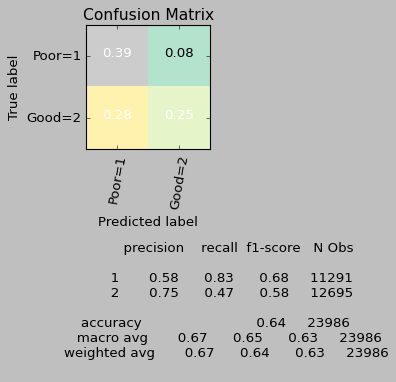

In [54]:
# Confusion matrix 

plt.style.use('classic')
plt.figure(figsize=(2,2))
pretty_print_conf_matrix(y_test_class, y_pred_NB_all_cat, 
                         classes= ['Poor=1', 'Good=2'],
                         normalize=True, 
                         title='Confusion Matrix')

As we see, once we changed the price feature to be categorical, the accuracy hasn`t chanched.  

## **XGBoost Classification Model**


After seeing a XGBoost Regression Model, we will build a XGBoost Classification Model. 

In [55]:
xgbc = xgb.XGBClassifier(n_estimators=100)
xgbc.fit(x_train_class, y_train_class)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [56]:
#Predict the response for test dataset
y_pred_XGBclass = xgbc.predict(x_test_class)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


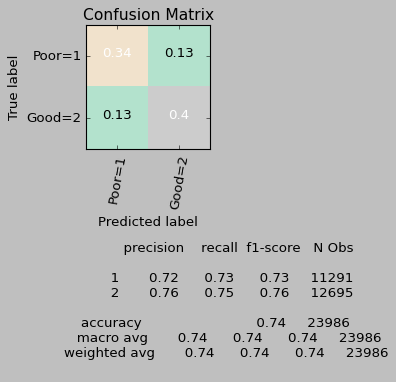

In [57]:
# Confusion matrix 

plt.style.use('classic')
plt.figure(figsize=(2,2))
pretty_print_conf_matrix(y_test_class, y_pred_XGBclass, 
                         classes= ['Poor=1', 'Good=2'],
                         normalize=True, 
                         title='Confusion Matrix')


Seems that the currunt XGBoost model is the one that provides the highest percentage of accuracy.